In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import math
import numpy as np
import copy
import time
import pickle
from random import seed, shuffle, sample

from sklearn.preprocessing import StandardScaler
from aif360.datasets import AdultDataset, CompasDataset, GermanDataset, BankDataset, StandardDataset

import matplotlib
import matplotlib.pyplot as plt
import os

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

%matplotlib inline

In [2]:
sys.path.append('../baselines/iFair/')
sys.path.append('../baselines/LFR/')
sys.path.append('../baselines/PFR/')
sys.path.append('../iFlipper/')

from iflipper import iFlipper
from aif360.algorithms.preprocessing import LFR
from iFair import iFair
from PFR import PFR, similarity_pfr, estimate_dim

from cplex_solver import CPLEX_Solver
from greedy import Greedy
from gradient import Gradient

from utils import measure_violations, similarity_knn, similarity_threshold
from model import Model

# Load fairness dataset from AIF360 and define variables
### 1. Dataset = COMPAS, AdultCensus, Credit
### 2. Similarity matrix = knn, threshold
### 3. ML model = LogisticRegression, RandomForest, NeuralNetwork

In [3]:
dataset_type = "COMPAS" # AdultCensus, Credit
similarity_matrix = "knn" # threshold
model_type = "LogisticRegression" # RandomForest, NeuralNetwork

PRINT_RESULT = True

In [4]:
if dataset_type == "COMPAS":
    dataset = CompasDataset(label_name='two_year_recid', favorable_classes=[0], 
                            protected_attribute_names=['sex'], privileged_classes=[['Female']], 
                            categorical_features=['age_cat', 'c_charge_degree', 'c_charge_desc', 'race'], 
                            features_to_keep=['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree', 'c_charge_desc', 'two_year_recid'], 
                            features_to_drop=[], na_values=[])
    protected = "sex"
    num_train, num_test, num_val = 0.6, 0.3, 0.1
    k, threshold = 20, 3
    num_plot = [1, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05, 0.01, 0.001, 0]
    
elif dataset_type == "AdultCensus":
    dataset = AdultDataset(label_name='income-per-year', favorable_classes=['>50K', '>50K.'], 
                    protected_attribute_names=['sex'], privileged_classes=[['Male']], 
                    categorical_features=['race', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'native-country'], 
                    features_to_keep=[], features_to_drop=['fnlwgt'], na_values=['?'])
    protected = "sex"
    num_train, num_test, num_val = 0.6, 0.3, 0.1
    k, threshold = 20, 3
    num_plot = [1, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05, 0.01, 0.005, 0.001, 0]
    
elif dataset_type == "Credit":
    def label_processing(df):
        credit_map = {1.0 : 1.0, 2.0 : 0.0}
        status_map = {'A91': 'male', 'A93': 'male', 'A94': 'male',
                      'A92': 'female', 'A95': 'female'}
        df['credit'] = df['credit'].replace(credit_map)
        df['sex'] = df['personal_status'].replace(status_map)    
        return df
    
    dataset = GermanDataset(custom_preprocessing = label_processing, 
                            metadata={'label_maps': [{1.0: 'Good Credit', 0.0: 'Bad Credit'}], 'protected_attribute_maps': [{1.0: 'Male', 0.0: 'Female'}, {1.0: 'Old', 0.0: 'Young'}]})
    protected = "age"
    num_train, num_test, num_val = 0.7, 0.2, 0.1
    k, threshold = 20, 7
    num_plot = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01]

privileged_groups = [{protected: 1}]
unprivileged_groups = [{protected: 0}]

In [5]:
scaler = StandardScaler()
train, test, val = dataset.split([num_train, num_train+num_test], shuffle=True, seed=0)

train.features = scaler.fit_transform(train.features)
test.features = scaler.fit_transform(test.features)
val.features = scaler.fit_transform(val.features)
index = train.feature_names.index(protected)

# remove sensitive features
x_train = np.delete(train.features, index, axis=1)
x_test = np.delete(test.features, index, axis=1)
x_val = np.delete(val.features, index, axis=1)

y_train = train.labels.ravel()
y_test = test.labels.ravel()
y_val = val.labels.ravel()

# keep sensitive column for PFR
train_sensitive = np.reshape(train.features[:, index], (-1, 1))
test_sensitive = np.reshape(test.features[:, index], (-1, 1))
val_sensitive = np.reshape(val.features[:, index], (-1, 1))

# For iFair
x_train_with_sensitive = np.concatenate((x_train, train_sensitive), axis = 1)
x_test_with_sensitive = np.concatenate((x_test, test_sensitive), axis = 1)
x_val_with_sensitive = np.concatenate((x_val, val_sensitive), axis = 1)

print("Dataset: %s" % dataset_type)
print("Number of training data: %d, Number of test data: %d, Number of validation data: %d\n" % (x_train.shape[0], x_test.shape[0], x_val.shape[0]))

Dataset: COMPAS
Number of training data: 3700, Number of test data: 1850, Number of validation data: 617



# Obtain similarity matrix

In [6]:
if similarity_matrix == "knn":
    w_train, edge_train = similarity_knn(x_train, k)
    w_test, edge_test = similarity_knn(x_test, k)
    w_val, edge_val = similarity_knn(x_val, k)
    
elif similarity_matrix == "threshold":
    w_train, edge_train = similarity_threshold(x_train, threshold)
    w_test, edge_test = similarity_threshold(x_test, threshold)
    w_val, edge_val = similarity_threshold(x_val, threshold)

# Initial number of violations

In [7]:
num_actual_violations, num_actual_flips, runtime = dict(), dict(), dict()

init_violations = measure_violations(y_train, edge_train)
print(f"Initial number of violations: {init_violations}")

Initial number of violations: 22327


# iFlipper on different target violation limits (m)

In [8]:
method = "iFlipper"
num_actual_violations[method], num_actual_flips[method], runtime[method] = [], [], []

for i in num_plot:
    m = int(init_violations * i)
        
    start = time.time()
    IFLIP = iFlipper(y_train, w_train, edge_train)
    flipped_label = IFLIP.transform(m)
    elapsed_time = time.time() - start

    num_violations = measure_violations(flipped_label, edge_train)
    num_flips = np.sum(y_train != flipped_label)

    num_actual_violations[method].append(num_violations)
    num_actual_flips[method].append(num_flips)
    runtime[method].append(elapsed_time)

    if PRINT_RESULT:
        print("============================")
        print(f"Target number of violations: {m}")
        print(f"Actual number of violations: {num_violations}")
        print(f"Number of flips: {num_flips}")
        print(f"Runtime (sec): {elapsed_time:.5f}")

Target number of violations: 22327
Actual number of violations: 22327
Number of flips: 0
Runtime (sec): 0.00071
Target number of violations: 17861
Actual number of violations: 17854
Number of flips: 192
Runtime (sec): 5.68390
Target number of violations: 13396
Actual number of violations: 13390
Number of flips: 445
Runtime (sec): 6.94905
Target number of violations: 8930
Actual number of violations: 8916
Number of flips: 734
Runtime (sec): 6.68959
Target number of violations: 4465
Actual number of violations: 4453
Number of flips: 1069
Runtime (sec): 7.44314
Target number of violations: 2232
Actual number of violations: 2226
Number of flips: 1274
Runtime (sec): 6.80725
Target number of violations: 1116
Actual number of violations: 1110
Number of flips: 1431
Runtime (sec): 9.95733
Target number of violations: 223
Actual number of violations: 215
Number of flips: 1554
Runtime (sec): 6.79878
Target number of violations: 22
Actual number of violations: 20
Number of flips: 1600
Runtime (sec

# Greedy algorithm
## Repeatedly flips label of nodes that reduce the number of violations the most

In [9]:
method = "Greedy"
num_actual_violations[method], num_actual_flips[method], runtime[method] = [], [], []

for i in num_plot:
    m = int(init_violations * i)
        
    start = time.time()
    flipped_label = Greedy(y_train, m, w_train, edge_train)
    elapsed_time = time.time() - start

    num_violations = measure_violations(flipped_label, edge_train)
    num_flips = np.sum(y_train != flipped_label)

    num_actual_violations[method].append(num_violations)
    num_actual_flips[method].append(num_flips)
    runtime[method].append(elapsed_time)

    if PRINT_RESULT:
        print("============================")
        print(f"Target number of violations: {m}")
        print(f"Actual number of violations: {num_violations}")
        print(f"Number of flips: {num_flips}")
        print(f"Runtime (sec): {elapsed_time:.5f}")

Target number of violations: 22327
Actual number of violations: 22327
Number of flips: 0
Runtime (sec): 0.00114
Target number of violations: 17861
Actual number of violations: 17857
Number of flips: 193
Runtime (sec): 23.38927
Target number of violations: 13396
Actual number of violations: 13391
Number of flips: 449
Runtime (sec): 47.08254
Target number of violations: 8930
Actual number of violations: 8928
Number of flips: 749
Runtime (sec): 73.78658
Target number of violations: 4465
Actual number of violations: 4457
Number of flips: 1101
Runtime (sec): 93.35106
Target number of violations: 2232
Actual number of violations: 2222
Number of flips: 1320
Runtime (sec): 108.93677
no more reduction
Target number of violations: 1116
Actual number of violations: 2209
Number of flips: 1324
Runtime (sec): 119.56492
no more reduction
Target number of violations: 223
Actual number of violations: 2209
Number of flips: 1324
Runtime (sec): 127.59877
no more reduction
Target number of violations: 22
A

# Gradient-based algorithm
## Solves an unconstrained optimization problem via gradient descent

In [14]:
method = "Gradient"
num_actual_violations[method], num_actual_flips[method], runtime[method] = [], [], []

for i in num_plot:
    m = int(init_violations * i)
        
    start = time.time()
    flipped_label = Gradient(y_train, m, w_train, edge_train, lam_high=60)
    elapsed_time = time.time() - start

    num_violations = measure_violations(flipped_label, edge_train)
    num_flips = np.sum(y_train != flipped_label)

    num_actual_violations[method].append(num_violations)
    num_actual_flips[method].append(num_flips)
    runtime[method].append(elapsed_time)

    if PRINT_RESULT:
        print("============================")
        print(f"Target number of violations: {m}")
        print(f"Actual number of violations: {num_violations}")
        print(f"Number of flips: {num_flips}")
        print(f"Runtime (sec): {elapsed_time:.5f}")

Target number of violations: 22327
Actual number of violations: 22185
Number of flips: 4
Runtime (sec): 39.39816
Target number of violations: 17861
Actual number of violations: 17586
Number of flips: 233
Runtime (sec): 37.90955
Target number of violations: 13396
Actual number of violations: 13279
Number of flips: 565
Runtime (sec): 42.99926
Target number of violations: 8930
Actual number of violations: 7805
Number of flips: 1052
Runtime (sec): 41.95722
Target number of violations: 4465
Actual number of violations: 5286
Number of flips: 1881
Runtime (sec): 39.09752
Target number of violations: 2232
Actual number of violations: 5605
Number of flips: 1714
Runtime (sec): 39.43828
Target number of violations: 1116
Actual number of violations: 4774
Number of flips: 1683
Runtime (sec): 37.91035
Target number of violations: 223
Actual number of violations: 5092
Number of flips: 1786
Runtime (sec): 39.51272
Target number of violations: 22
Actual number of violations: 5718
Number of flips: 1923


# ILP Solver (using CPLEX)
## Solves the ILP problem exactly

In [11]:
method = "ILP Solver"
num_actual_violations[method], num_actual_flips[method], runtime[method] = [], [], []

for i in num_plot:
    m = int(init_violations * i)
        
    start = time.time()
    flipped_label = CPLEX_Solver(y_train, m, edge_train, ILP = True)
    elapsed_time = time.time() - start

    num_violations = measure_violations(flipped_label, edge_train)
    num_flips = np.sum(y_train != flipped_label)

    num_actual_violations[method].append(num_violations)
    num_actual_flips[method].append(num_flips)
    runtime[method].append(elapsed_time)

    if PRINT_RESULT:
        print("============================")
        print(f"Target number of violations: {m}")
        print(f"Actual number of violations: {num_violations}")
        print(f"Number of flips: {num_flips}")
        print(f"Runtime (sec): {elapsed_time:.5f}")

Target number of violations: 22327
Actual number of violations: 22327
Number of flips: 0
Runtime (sec): 80.46017
Target number of violations: 17861
Actual number of violations: 17854
Number of flips: 192
Runtime (sec): 226.78379
Target number of violations: 13396
Actual number of violations: 13393
Number of flips: 444
Runtime (sec): 165.06881
Target number of violations: 8930
Actual number of violations: 8930
Number of flips: 733
Runtime (sec): 163.79426
Target number of violations: 4465
Actual number of violations: 4465
Number of flips: 1068
Runtime (sec): 136.02159
Target number of violations: 2232
Actual number of violations: 2232
Number of flips: 1274
Runtime (sec): 788.18128
Target number of violations: 1116
Actual number of violations: 1116
Number of flips: 1407
Runtime (sec): 365.60311
Target number of violations: 223
Actual number of violations: 223
Number of flips: 1540
Runtime (sec): 693.42839
Target number of violations: 22
Actual number of violations: 20
Number of flips: 16

# Optimization solutions comparison
### 1. Actual number of violations
### 2. Number of flips
### 3. Runtime (sec)

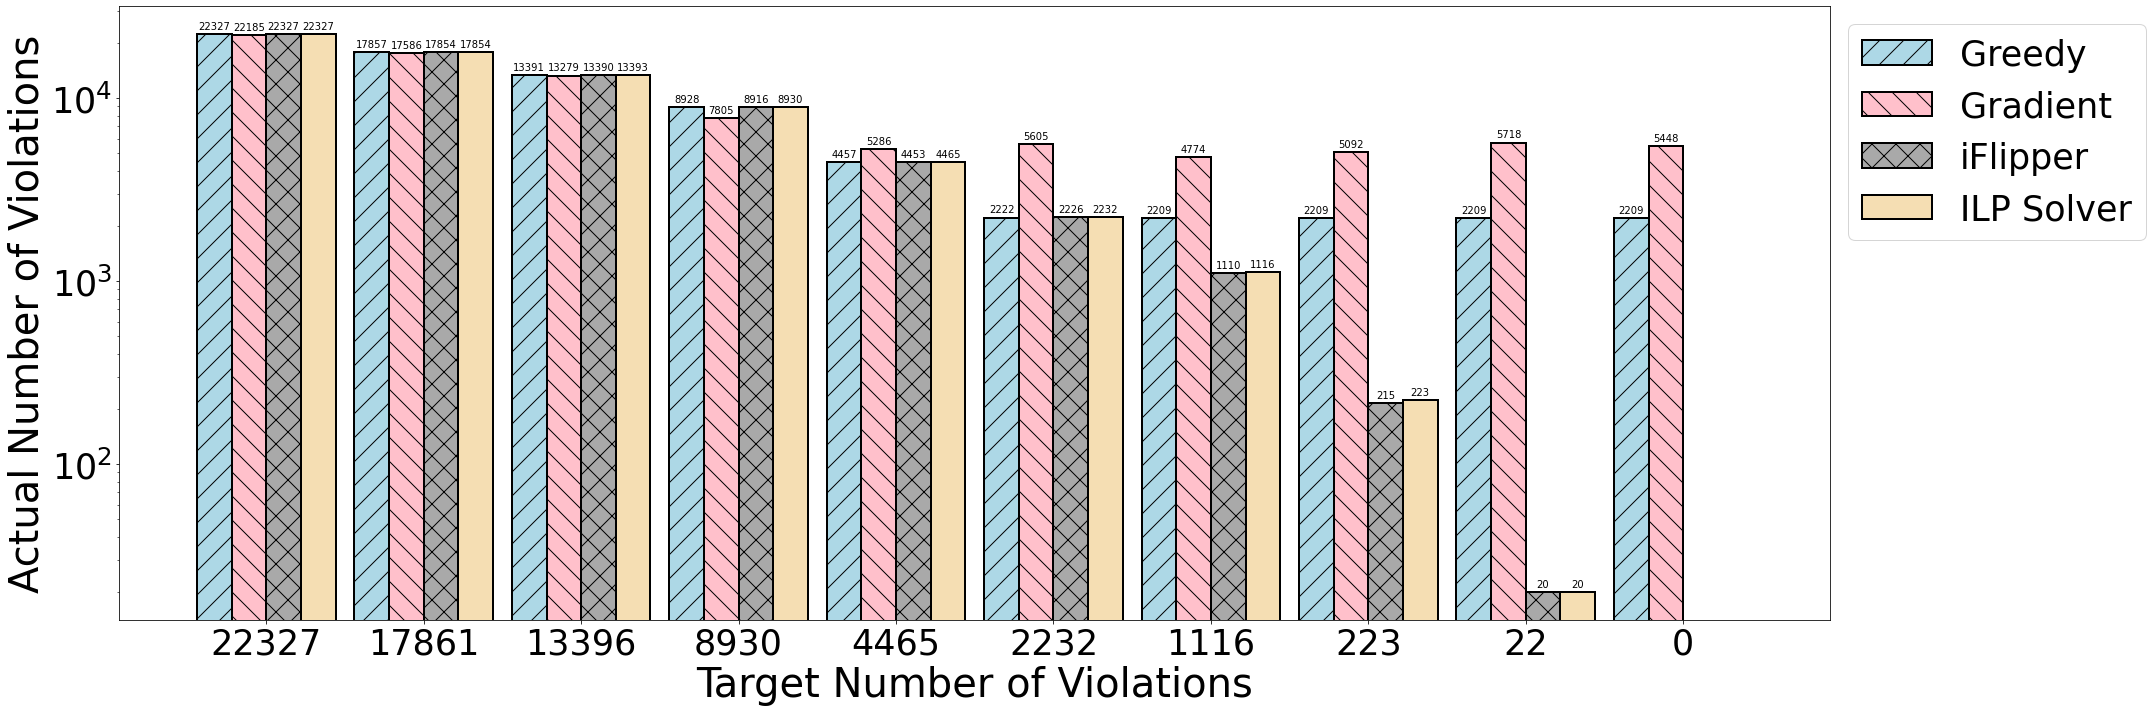

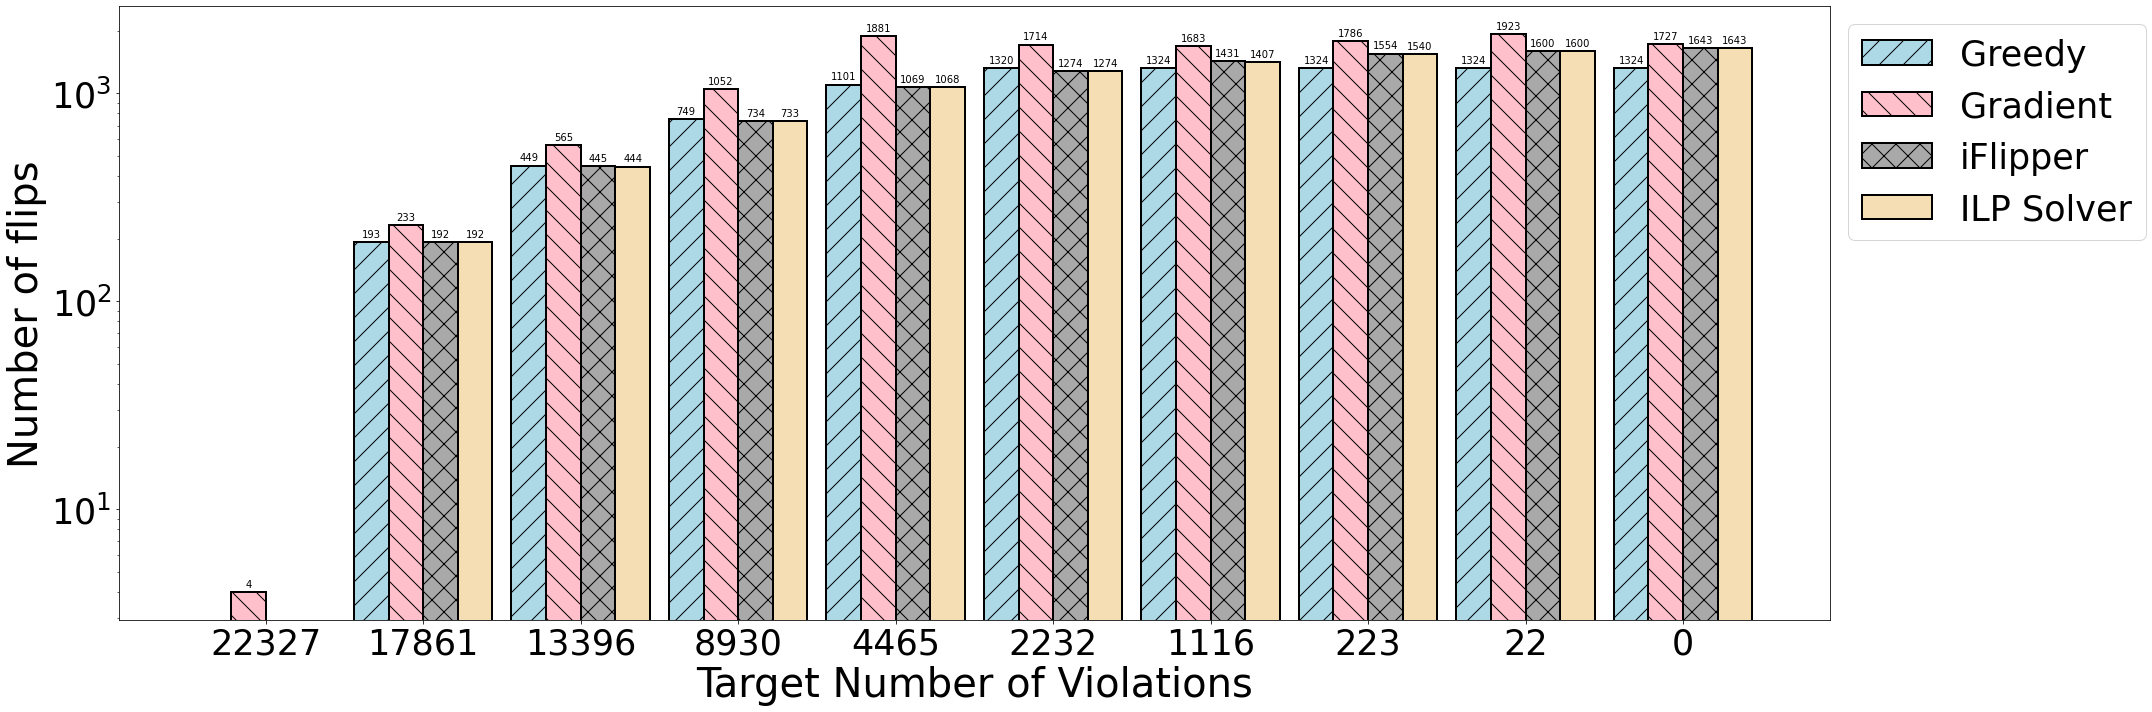

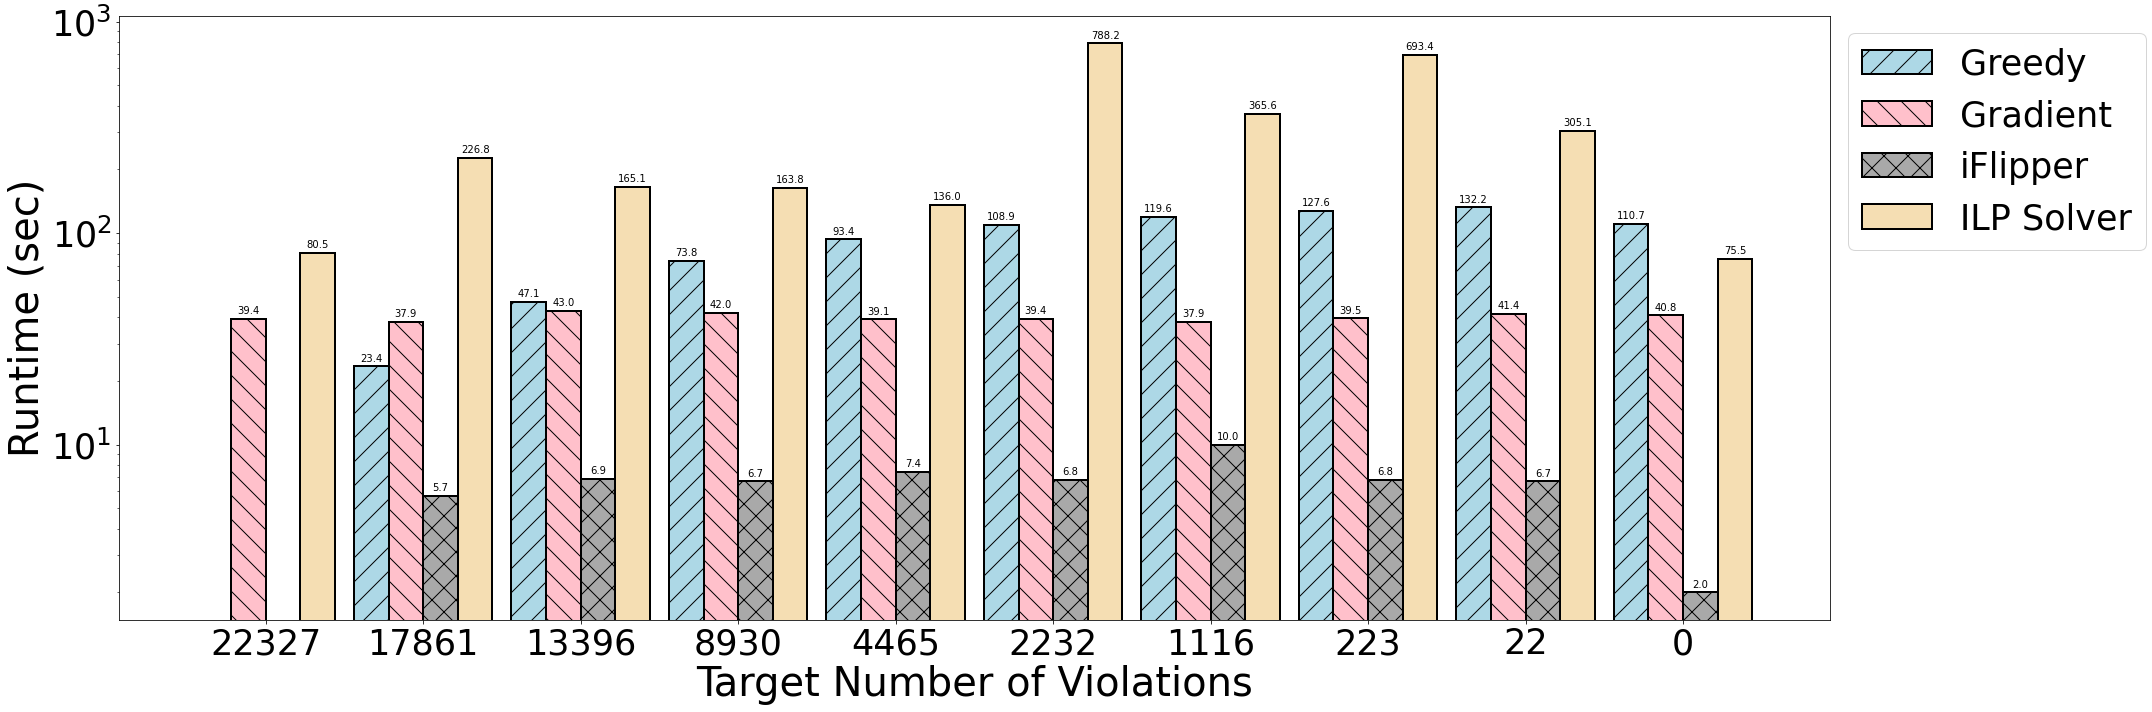

In [15]:
def plot_result(m_list, performance_arr, y_axis, num_digits):
    labels = m_list

    plot1 = np.array(performance_arr["Greedy"])
    plot2 = np.array(performance_arr["Gradient"])
    plot3 = np.array(performance_arr["iFlipper"])
    plot4 = np.array(performance_arr["ILP Solver"])

    x = np.arange(len(labels)) # the label locations
    width = 0.22  # the width of the bars

    plt.figure(1, figsize=(30,10))
    ax = plt.subplot()

    rects1 = ax.bar(x - width * 1.5, np.round(plot1, num_digits), width, label="Greedy", color="lightblue", hatch='/',edgecolor="black", linewidth=2)
    rects2 = ax.bar(x - width * 0.5, np.round(plot2, num_digits), width, label="Gradient", color="pink", hatch='\\',edgecolor="black", linewidth=2)
    rects3 = ax.bar(x + width * 0.5, np.round(plot3, num_digits), width, label="iFlipper", color="darkgray", hatch='x',edgecolor="black", linewidth=2)
    rects4 = ax.bar(x + width * 1.5, np.round(plot4, num_digits), width, label="ILP Solver", color="wheat", edgecolor="black", linewidth=2)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.tick_params(labelsize=35)
    ax.set_ylabel(y_axis, fontsize=40)
    ax.set_xlabel("Target Number of Violations", fontsize=40)

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if y_axis == "Runtime (sec)" or y_axis == "Actual Number of Violations" or y_axis == "Number of flips":
        ax.set_yscale('log')
    
    ax.legend(prop={'size':35}, bbox_to_anchor=(1, 1), loc='upper left')

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)

    plt.tight_layout()
    plt.show()

m_list = []
for i in num_plot:
    m = int(init_violations * i)
    m_list.append(m)

plot_result(m_list, num_actual_violations, "Actual Number of Violations", 0)
plot_result(m_list, num_actual_flips, "Number of flips", 0)
plot_result(m_list, runtime, "Runtime (sec)", 1)